### <div style="text-align: center">Credit Card Fraud Detection</div> 
### <div style="text-align: center"> Part 3 </div> 



<div style="text-align: center; font-size: 120%"> 12/08/2020</div>


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# from sklearn.model_selection import cross_validate as CV
# from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

### Import files

In [84]:
Xtrain = pd.read_csv('data/Xtrain.csv', index_col=0)
ytrain = pd.read_csv('data/ytrain.csv', index_col=0).iloc[:,0]
Xval = pd.read_csv('data/Xval.csv', index_col=0)
yval = pd.read_csv('data/yval.csv', index_col=0).iloc[:,0]
Xtest = pd.read_csv('data/Xtest.csv', index_col=0)
ytest = pd.read_csv('data/ytest.csv', index_col=0).iloc[:,0]


print(f'Train set:      {Xtrain.shape},  labels:  {ytrain.shape}')
print(f'Validation set:  {Xval.shape},  labels:  {yval.shape}')
print(f'Test set:        {Xtest.shape},  labels:  {ytest.shape}\n')

print(f'Fraud in train:      {ytrain.mean(): .2%}')
print(f'Fraud in validation: {yval.mean(): .2%}')
print(f'Fraud in test:        {ytest.mean():.2%}')

Train set:      (170883, 30),  labels:  (170883,)
Validation set:  (56962, 30),  labels:  (56962,)
Test set:        (56962, 30),  labels:  (56962,)

Fraud in train:       0.17%
Fraud in validation:  0.17%
Fraud in test:        0.17%


In [85]:
feats = Xtrain.columns.tolist()
print(feats)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_hour']


### My helper functions

In [96]:
def disp_conf_matrix(true, pred):
    df = pd.DataFrame(confusion_matrix(true, pred), columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])
    display(df)

    
def calc_highest_f1(ytrue, ypred_proba):
    '''In case of Logistic Regression Classifier this function will return the max F1-score and the
    corresponding treshold.'''
    precision, recall, thresholds = precision_recall_curve(ytrue, ypred_proba)
    f1 = precision * recall / (precision + recall) * 2
    idx_maxf1 = np.argmax(f1)
    tresh, max_f1 = thresholds[idx_maxf1], f1[idx_maxf1]
    return max_f1, tresh

def print_train_val_result(logreg):
    '''Given a Logistic Regression Classifier the function will print the result on train and validation set.'''
    #result on the train_sample
    pred_train_proba = logreg.predict_proba(Xtrain_sample)[:, 1]
    auc_train = roc_auc_score(ytrain_sample, pred_train_proba)
    f1_train = f1_score(ytrain_sample, np.round(pred_train_proba))

    #result on validation set
    pred_val_proba = logreg.predict_proba(Xval)[:, 1]
    auc_val = roc_auc_score(yval, pred_val_proba)
    f1_val, tresh = calc_highest_f1(yval, pred_val_proba)


    print(f'Params: C: {logreg.C:}, l1_ratio: {logreg.l1_ratio}')
    print(f'Training result -----------   Validation result --------------------------------')
    print(f'AUC: {auc_train:.3f}, F1-score: {f1_train:.3f}   ', end='')
    print(f'AUC: {auc_val:.3f}, max F1-score: {f1_val:.3f} at treshold: {tresh:.3f}')
    
def print_feats(logreg):
    '''Given a logistic regression classifier, plots the features with non-zero coefs sorted by their magnitude'''
    logreg_feats = pd.DataFrame(zip(feats, np.abs(logreg.coef_[0])), columns=['Feature', 'Coefficient_abs'])
    display(logreg_feats.loc[logreg_feats['Coefficient_abs']!=0].sort_values(by='Coefficient_abs', ascending=False))
    
def plot_roc_prc(clfs, names, save_path=None, suptitle=None):
    '''Given the list of classifiers, displays the ROC and Precision-Recall Curve w.r.t. the test set'''
    assert len(clfs) == len(names)
    
    fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(12,5.5), dpi=200)
    
    for i in range(len(clfs)): 
        pred_test_proba = clfs[i].predict_proba(Xtest)[:,1]
        precision, recall, t_prcurve = precision_recall_curve(ytest, pred_test_proba)
        fpr, tpr, t_roccurve = roc_curve(ytest, pred_test_proba)

        ax1.plot(fpr, tpr, label=names[i])
        ax1.set_title('Receiver-Operator Curve', fontsize=10)
        ax1.plot([0,1], [0,1], linestyle='--', c='r')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')

        ax2.plot(precision, recall, label=names[i])
        ax2.set_title('Precision-Recall Curve', fontsize=10)
        ax2.plot([0,1], [0,0], linestyle='--', c='r')
        ax2.set_xlabel('Precision')
        ax2.set_ylabel('Recall')


    ax1.legend(frameon=False, loc='lower right', bbox_to_anchor=(1, 0.1))
    ax2.legend(frameon=False, loc='lower left', bbox_to_anchor=(0, 0.1))
    
    if suptitle:
        plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, transparent=False, dpi=200, facecolor='white')
        
    plt.show()

##   
## 4. Supervised Fraud Detection

### 4.1. Logistic Regression

### Creating a more balanced dataset

We will make it in three steps:
* Downsample the majority class to 10,000 observations
* Using SMOTE to create 10,000 observations of fraud
* Adding additional 40,000 observations from the majority class

It will result a 4:1 ratio for normal and fraud observations, a more balanced dataset compared to the original dataset.

Make sure to install package:   
https://imbalanced-learn.org/stable/install.html

In [5]:
# 1.)
#only normal observations from the Xtrain set:
Xtrain_normal = Xtrain.loc[ytrain==0]

#create sample of 10,000 from normal observations:
np.random.seed(1)
idx_normal_sample = np.random.choice(len(Xtrain_normal), size=10000, replace=False)
Xtrain_normal_sample = Xtrain_normal.iloc[idx_normal_sample]

#combine 10,000 normal sample with fraud from Xtrain
Xtrain_fraud = Xtrain.loc[ytrain==1]
Xtrain_sample = pd.concat([Xtrain_normal_sample, Xtrain_fraud])
ytrain_sample = pd.Series([0]*len(Xtrain_normal_sample) + [1]*len(Xtrain_fraud))

# 2.)
#create synthetic samples with SMOTE
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE(sampling_strategy = 'minority', random_state=1).fit_resample(Xtrain_sample, ytrain_sample)

# 3.)
#create sample of 40,000 from normal observations:
np.random.seed(1)
idx_normal_sample = np.random.choice(len(Xtrain_normal), size=40000, replace=False)
Xtrain_normal_sample = Xtrain_normal.iloc[idx_normal_sample]

#combine 40,000 normal sample with 10,000 fraud from SMOTE
X_smote_fraud = X_smote.loc[y_smote==1]
Xtrain_sample = pd.concat([Xtrain_normal_sample, X_smote_fraud])
ytrain_sample = pd.Series([0]*len(Xtrain_normal_sample) + [1]*len(X_smote_fraud))

In [77]:
#Save into a data folder:
# Xtrain_sample.to_csv('data/Xtrain_sample.csv')
# ytrain_sample.to_csv('data/ytrain_sample.csv')

#Import data from the folder:
# Xtrain_sample = pd.read_csv('data/Xtrain_sample.csv', index_col=0)
# ytrain_sample = pd.read_csv('data/ytrain_sample.csv', index_col=0).iloc[:,0]

In [78]:
print(f'Balanced set:      {Xtrain_sample.shape},  labels:  {ytrain_sample.shape}')
print(f'Fraud in train:      {ytrain_sample.mean(): .2%}')

Balanced set:      (50000, 30),  labels:  (50000,)
Fraud in train:       20.00%


### Training Logistic Regression

The model performance and the F1-score of the Logistic Regression model is highly depend on the threshold value, that is why I will choose the best model both the AUC score and F1-score on the validation set. If two models have closely the same result I prefer the one with less variables (more L1 regularization).

#### A.) Vanilla model

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='elasticnet',
                            C=10000,
                            class_weight={0: 0.8, 1: 0.2},
                            random_state=1,
                            solver='saga',
                            max_iter=5000,
                            n_jobs=-1,
                            l1_ratio=1)

logreg.fit(Xtrain_sample, ytrain_sample)

print_train_val_result(logreg)

Params: C: 10000, l1_ratio: 1
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.979, max F1-score: 0.806 at treshold: 0.994


#### B.) Find the best feature set using Lasso regression

In [8]:
C = 0.0001
logreg = LogisticRegression(penalty='elasticnet',
                            C=C,
                            class_weight={0: 0.8, 1: 0.2},
                            random_state=1,
                            solver='saga',
                            max_iter=5000,
                            n_jobs=-1,
                            l1_ratio=1)

logreg.fit(Xtrain_sample, ytrain_sample)

print_train_val_result(logreg)

logreg_feats = pd.DataFrame(zip(feats, np.abs(logreg.coef_[0])), columns=['Feature', 'Coefficient_abs'])
display(logreg_feats.loc[logreg_feats['Coefficient_abs']!=0].sort_values(by='Coefficient_abs', ascending=False))

Params: C: 0.0001, l1_ratio: 1
Training result -----------   Validation result --------------------------------
AUC: 0.961, F1-score: 0.040   AUC: 0.948, max F1-score: 0.622 at treshold: 0.131


,Feature,Coefficient_abs
13,V14,0.180530
2,V3,0.006952


In [9]:
C = 0.001
logreg = LogisticRegression(penalty='elasticnet',
                            C=C,
                            class_weight={0: 0.8, 1: 0.2},
                            random_state=1,
                            solver='saga',
                            max_iter=5000,
                            n_jobs=-1,
                            l1_ratio=1)

logreg.fit(Xtrain_sample, ytrain_sample)

print_train_val_result(logreg)

logreg_feats = pd.DataFrame(zip(feats, np.abs(logreg.coef_[0])), columns=['Feature', 'Coefficient_abs'])
display(logreg_feats.loc[logreg_feats['Coefficient_abs']!=0].sort_values(by='Coefficient_abs', ascending=False))

Params: C: 0.001, l1_ratio: 1
Training result -----------   Validation result --------------------------------
AUC: 0.974, F1-score: 0.845   AUC: 0.968, max F1-score: 0.722 at treshold: 0.507


,Feature,Coefficient_abs
13,V14,0.757166
3,V4,0.178766
9,V10,0.086993
11,V12,0.067979


In [10]:
C = 0.01
logreg = LogisticRegression(penalty='elasticnet',
                            C=C,
                            class_weight={0: 0.8, 1: 0.2},
                            random_state=2,
                            solver='saga',
                            max_iter=5000,
                            n_jobs=-1,
                            l1_ratio=1)

logreg.fit(Xtrain_sample, ytrain_sample)

print_train_val_result(logreg)

logreg_feats = pd.DataFrame(zip(feats, np.abs(logreg.coef_[0])), columns=['Feature', 'Coefficient_abs'])
display(logreg_feats.loc[logreg_feats['Coefficient_abs']!=0].sort_values(by='Coefficient_abs', ascending=False))

Params: C: 0.01, l1_ratio: 1
Training result -----------   Validation result --------------------------------
AUC: 0.983, F1-score: 0.899   AUC: 0.987, max F1-score: 0.771 at treshold: 0.728


,Feature,Coefficient_abs
13,V14,0.797179
3,V4,0.605537
9,V10,0.437047
11,V12,0.390725
7,V8,0.173735
10,V11,0.039528
16,V17,0.036574
5,V6,0.019181
0,V1,0.012717
12,V13,0.008212


In [11]:
C = 0.05
logreg = LogisticRegression(penalty='elasticnet',
                            C=C,
                            class_weight={0: 0.8, 1: 0.2},
                            random_state=2,
                            solver='saga',
                            max_iter=5000,
                            n_jobs=-1,
                            l1_ratio=1)

logreg.fit(Xtrain_sample, ytrain_sample)

print_train_val_result(logreg)

logreg_feats = pd.DataFrame(zip(feats, np.abs(logreg.coef_[0])), columns=['Feature', 'Coefficient_abs'])
display(logreg_feats.loc[logreg_feats['Coefficient_abs']!=0].sort_values(by='Coefficient_abs', ascending=False))

Params: C: 0.05, l1_ratio: 1
Training result -----------   Validation result --------------------------------
AUC: 0.985, F1-score: 0.906   AUC: 0.983, max F1-score: 0.796 at treshold: 0.969


,Feature,Coefficient_abs
3,V4,0.827684
13,V14,0.781467
9,V10,0.654307
11,V12,0.436156
7,V8,0.310153
12,V13,0.226943
15,V16,0.215911
21,V22,0.187222
16,V17,0.158049
10,V11,0.148653


#### C.) Find the best parameters (alpha, lambda) in Elastic-net

In [13]:
C_params = [0.05, 0.01, 0.005]
l1_ratio = np.round(np.linspace(0, 1, 6), 2)

for C in C_params:
    for l in l1_ratio:
        logreg = LogisticRegression(penalty='elasticnet',
                                    C=C,
                                    class_weight={0: 0.8, 1: 0.2},
                                    random_state=1,
                                    solver='saga',
                                    max_iter=5000,
                                    n_jobs=-1,
                                    l1_ratio=l)

        logreg.fit(Xtrain_sample, ytrain_sample)
        print_train_val_result(logreg)
        print()

Params: C: 0.05, l1_ratio: 0.0
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.981, max F1-score: 0.798 at treshold: 0.979

Params: C: 0.05, l1_ratio: 0.2
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.981, max F1-score: 0.796 at treshold: 0.986

Params: C: 0.05, l1_ratio: 0.4
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.982, max F1-score: 0.794 at treshold: 0.970

Params: C: 0.05, l1_ratio: 0.6
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.982, max F1-score: 0.796 at treshold: 0.979

Params: C: 0.05, l1_ratio: 0.8
Training result -----------   Validation result --------------------------------
AUC: 0.986, F1-score: 0.906   AUC: 0.983, max F1-score: 0.796 at treshold: 0.974

Params: C: 0.05, l1_ratio: 1.0

#### D.) Test the model with the best parameters

In [86]:
#Best params:
C = 0.005
l1_ratio = 0.4

logreg_clf = LogisticRegression(penalty='elasticnet',
                                C=C,
                                class_weight={0: 0.8, 1: 0.2},
                                random_state=1,
                                solver='saga',
                                max_iter=5000,
                                n_jobs=-1,
                                l1_ratio=l1_ratio)

logreg_clf.fit(Xtrain_sample, ytrain_sample)
#print train and val result
print_train_val_result(logreg_clf)

#result on test set
pred_test_proba = logreg_clf.predict_proba(Xtest)[:, 1]
pred_test = np.where(pred_test_proba>0.893, 1, 0)
auc_test = roc_auc_score(ytest, pred_test_proba)
f1_test = f1_score(ytest, pred_test)

print(f'Test result ---------------')
print(f'AUC: {auc_test:.3f}, F1-score: {f1_test:.3f}   ', end='')

Params: C: 0.005, l1_ratio: 0.4
Training result -----------   Validation result --------------------------------
AUC: 0.984, F1-score: 0.898   AUC: 0.988, max F1-score: 0.785 at treshold: 0.793
Test result ---------------
AUC: 0.979, F1-score: 0.833   

In [87]:
print(classification_report(ytest, pred_test, digits=3))
disp_conf_matrix(ytest, pred_test)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56864
           1      0.802     0.867     0.833        98

    accuracy                          0.999     56962
   macro avg      0.901     0.933     0.917     56962
weighted avg      0.999     0.999     0.999     56962



,Pred_0,Pred_1
True_0,56843,21
True_1,13,85


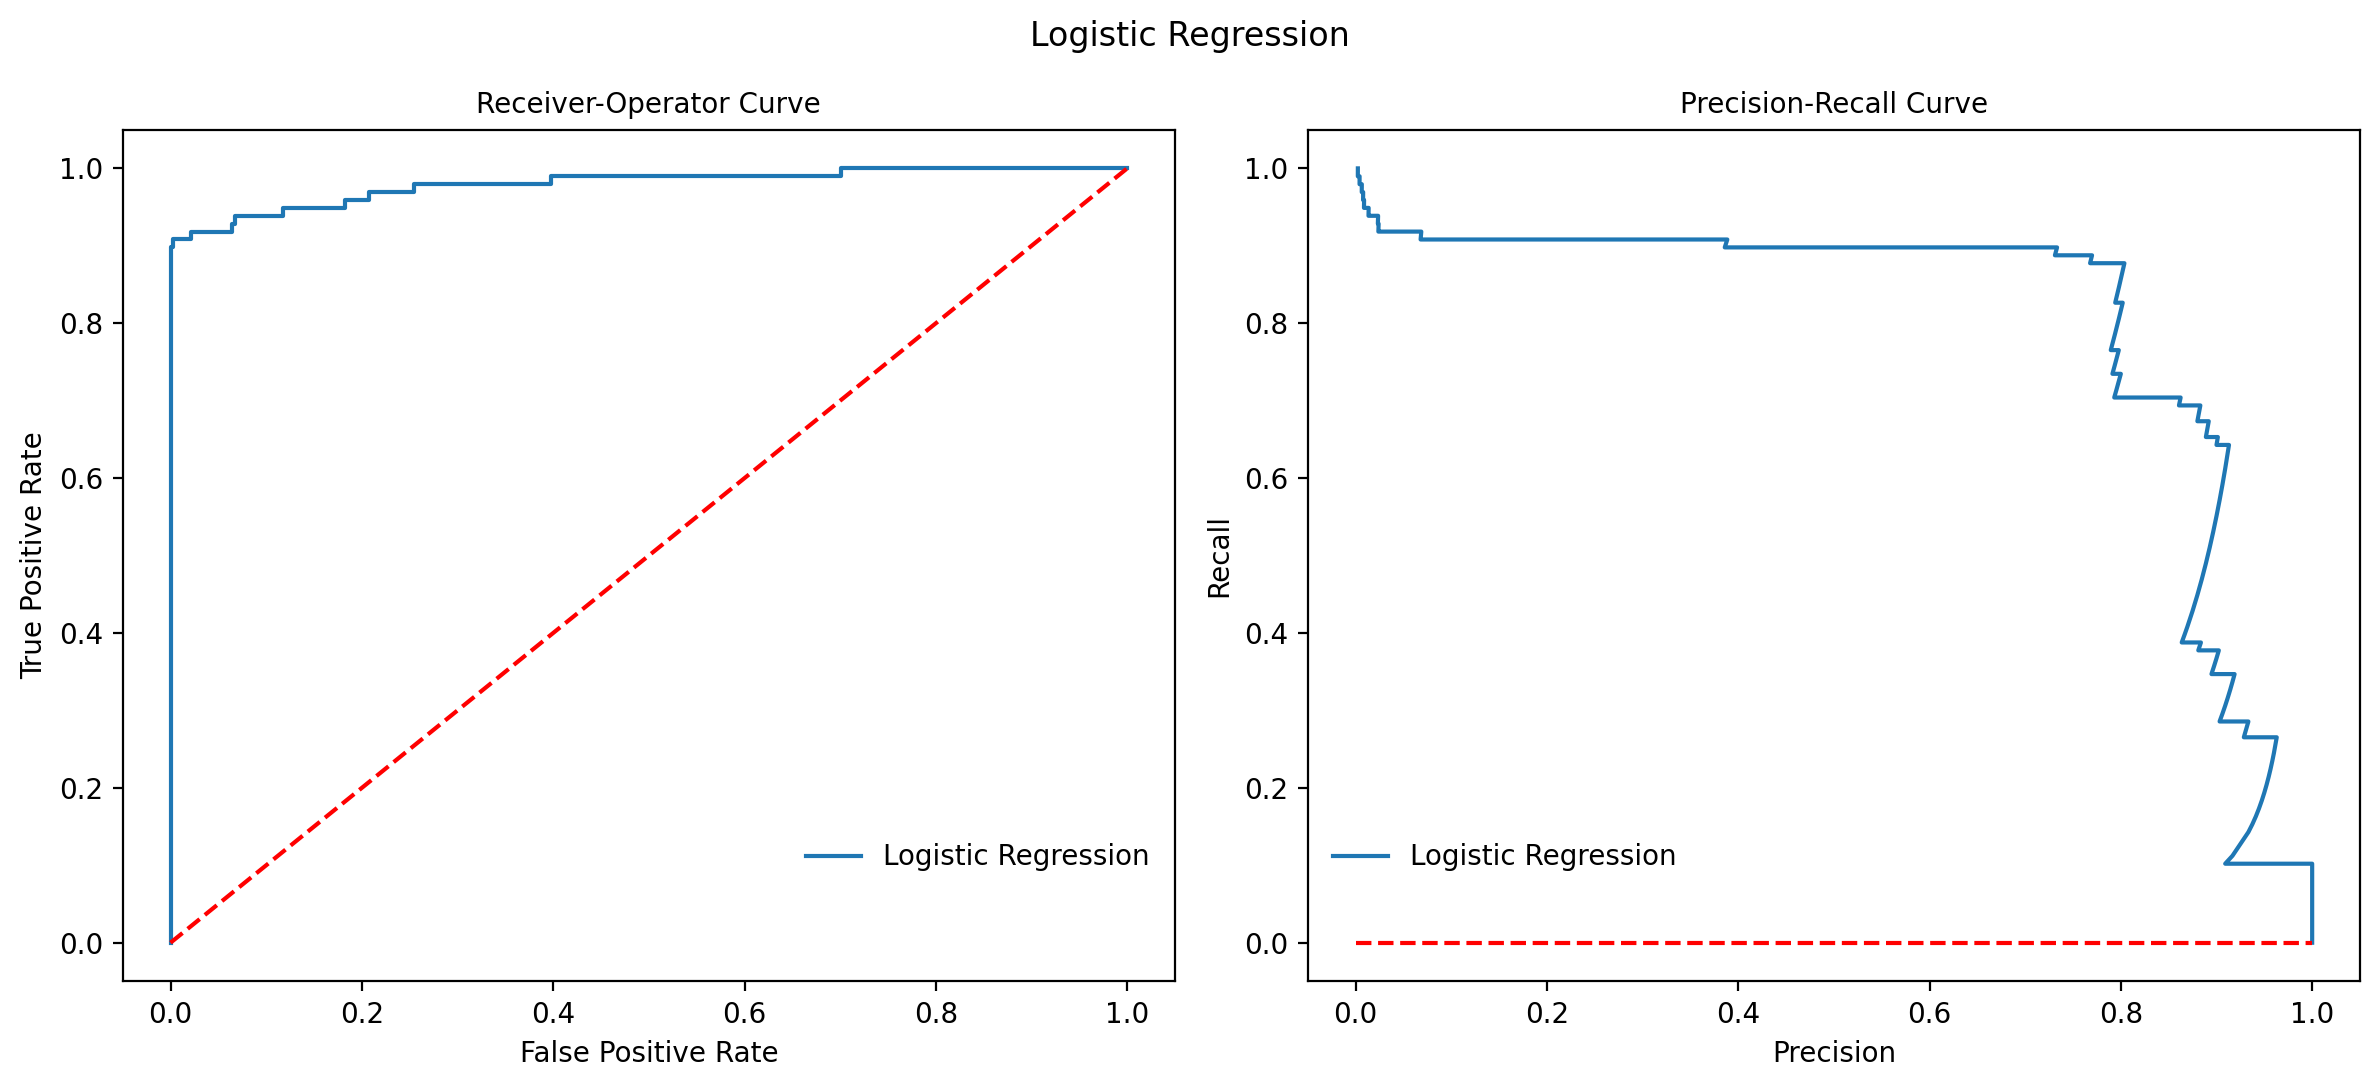

In [100]:
plot_roc_prc([logreg_clf], ['Logistic Regression'], save_path='img/ROC_logreg.png', suptitle='Logistic Regression')

In [17]:
print_feats(logreg_clf)

,Feature,Coefficient_abs
13,V14,0.724926
3,V4,0.576670
9,V10,0.398286
11,V12,0.366008
7,V8,0.177766
10,V11,0.109822
12,V13,0.049418
5,V6,0.045079
16,V17,0.037963
15,V16,0.033556



###   
### 4.2. Boosting Algorithm (Random Forest OR XGBoost OR Light Gradient Boosting OR Adaboosting)

### 4.2.1. Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                max_depth=5, 
                                min_samples_split=5, 
                                min_samples_leaf=5, 
                                random_state=1)
                            
rf_clf.fit(Xtrain, ytrain)
pred_val = rf_clf.predict(Xval)

#report
print(classification_report(yval, pred_val, digits=3))
disp_conf_matrix(yval, pred_val)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56863
           1      0.923     0.727     0.814        99

    accuracy                          0.999     56962
   macro avg      0.961     0.864     0.907     56962
weighted avg      0.999     0.999     0.999     56962



,Pred_0,Pred_1
True_0,56857,6
True_1,27,72


#### Parameter tuning using the validation set

In [19]:
max_depth_params = [3,4,5,6,8,10]

f1_highest = 0
for p in max_depth_params: 
    rf_clf = RandomForestClassifier(n_estimators=150, criterion='entropy',
                                    max_depth=p, 
                                    min_samples_split=5, 
                                    min_samples_leaf=5, 
                                    random_state=1)
    rf_clf.fit(Xtrain, ytrain)
    pred_val = rf_clf.predict(Xval)
    f1 = f1_score(yval, pred_val)
    if f1 > f1_highest:
        print(f'F1: {f1:.3f} at max_depth: {p}')
        f1_highest = f1

F1: 0.754 at max_depth: 3
F1: 0.785 at max_depth: 4
F1: 0.827 at max_depth: 5
F1: 0.847 at max_depth: 8
F1: 0.860 at max_depth: 10


#### Test the model

In [20]:
rf_clf = RandomForestClassifier(n_estimators=150, criterion='entropy',
                                max_depth=10, 
                                min_samples_split=5, 
                                min_samples_leaf=5, 
                                random_state=1)
                            
rf_clf.fit(Xtrain, ytrain)
pred_test = rf_clf.predict(Xtest)

#report
print(classification_report(ytest, pred_test, digits=3))
disp_conf_matrix(ytest, pred_test)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56864
           1      0.943     0.837     0.886        98

    accuracy                          1.000     56962
   macro avg      0.971     0.918     0.943     56962
weighted avg      1.000     1.000     1.000     56962



,Pred_0,Pred_1
True_0,56859,5
True_1,16,82


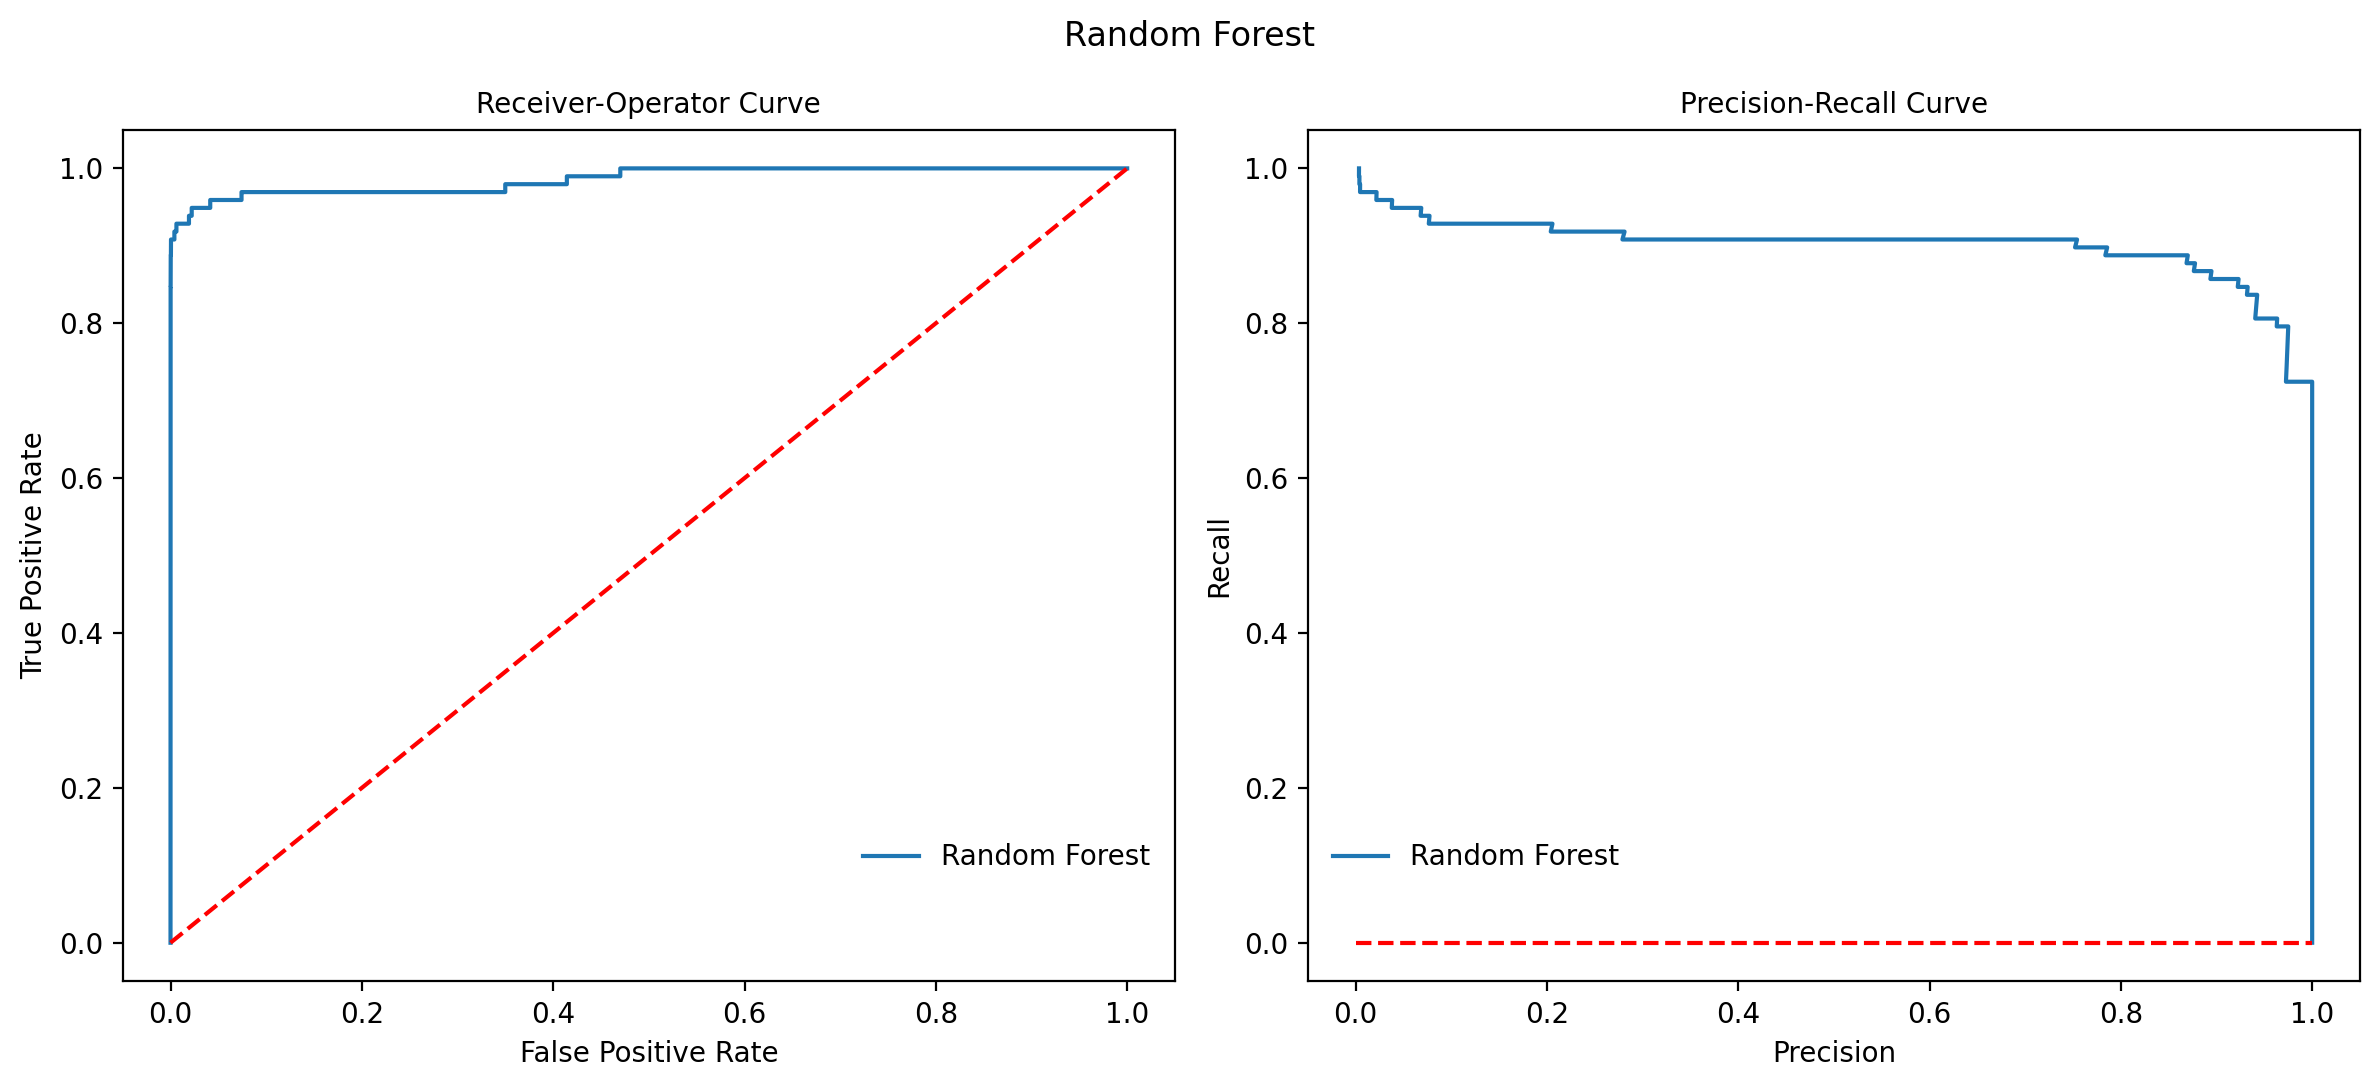

In [99]:
plot_roc_prc([rf_clf], ['Random Forest'], 'img/ROC_rf.png', 'Random Forest');

#### Feature Importance

In [22]:
rf_feats = pd.DataFrame(zip(feats, rf_clf.feature_importances_), columns=['Feature', 'Importance'])
rf_feats.sort_values(by='Importance', ascending=False)

,Feature,Importance
16,V17,0.189991
13,V14,0.152302
11,V12,0.150840
9,V10,0.086636
10,V11,0.069266
3,V4,0.054001
15,V16,0.050643
2,V3,0.032830
6,V7,0.029299
17,V18,0.020039


###     
### 4.3. Artificial Neural Network

#### 4.3.1. Train the model using Sklearn 

In [23]:
from sklearn.neural_network import MLPClassifier

In [24]:
ann_clf = MLPClassifier(hidden_layer_sizes=(40, 20), 
                        activation='tanh',
                        alpha=0.0001,
                        solver='sgd',
                        random_state=2,
                        learning_rate_init=0.1,
                        max_iter=200,
                        tol=0.0001)

In [25]:
ann_clf.fit(Xtrain, ytrain)

MLPClassifier(activation='tanh', hidden_layer_sizes=(40, 20),
              learning_rate_init=0.1, random_state=2, solver='sgd')

In [26]:
pred_train = ann_clf.predict(Xtrain)
pred_val = ann_clf.predict(Xval)
print(f'Train F1-score: {f1_score(ytrain, pred_train):.3f}')
print(f'Val F1-score: {f1_score(yval, pred_val):.3f}')
print(f'Params: activation function: ({ann_clf.activation})  hidden layers: ({ann_clf.hidden_layer_sizes})')

Train F1-score: 0.869
Val F1-score: 0.862
Params: activation function: (tanh)  hidden layers: ((40, 20))


In [27]:
clf = ann_clf
pred_val = clf.predict(Xval)
print(f'F1-score: {f1_score(yval, pred_val):.3f}')
print(f'Params: activation function: ({ann_clf.activation})  hidden layers: ({ann_clf.hidden_layer_sizes})')

F1-score: 0.862
Params: activation function: (tanh)  hidden layers: ((40, 20))


In [28]:
pred_test = clf.predict(Xtest)

print(classification_report(ytest, pred_test, digits=3))
disp_conf_matrix(ytest, pred_test)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     56864
           1      0.912     0.847     0.878        98

    accuracy                          1.000     56962
   macro avg      0.956     0.923     0.939     56962
weighted avg      1.000     1.000     1.000     56962



,Pred_0,Pred_1
True_0,56856,8
True_1,15,83


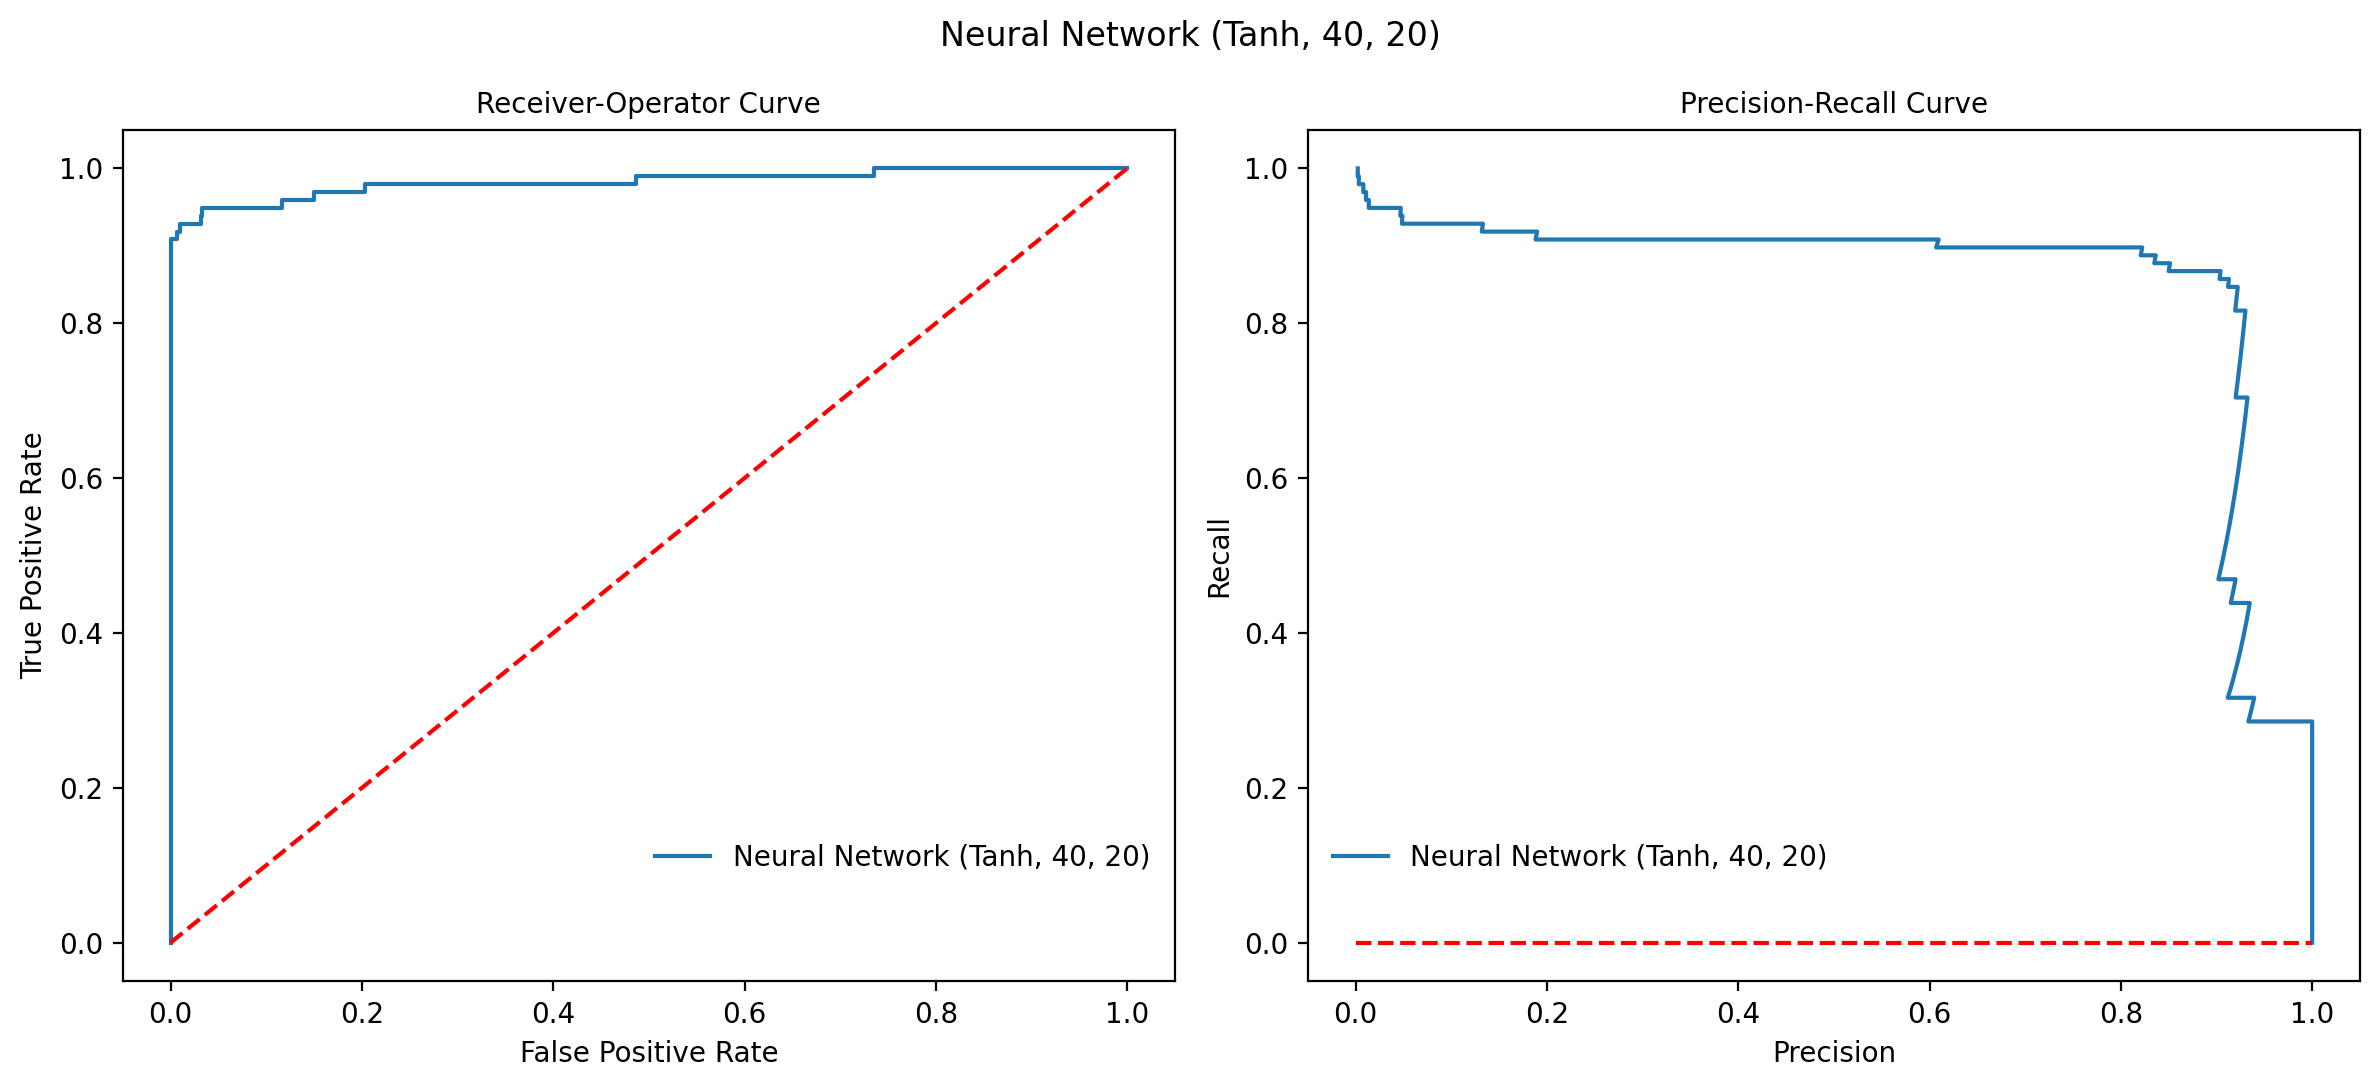

In [98]:
plot_roc_prc([ann_clf], ['Neural Network (Tanh, 40, 20)'], 'img/ROC_nn.png', 'Neural Network (Tanh, 40, 20)');

###      
### 4.4. Compare the models in one plot

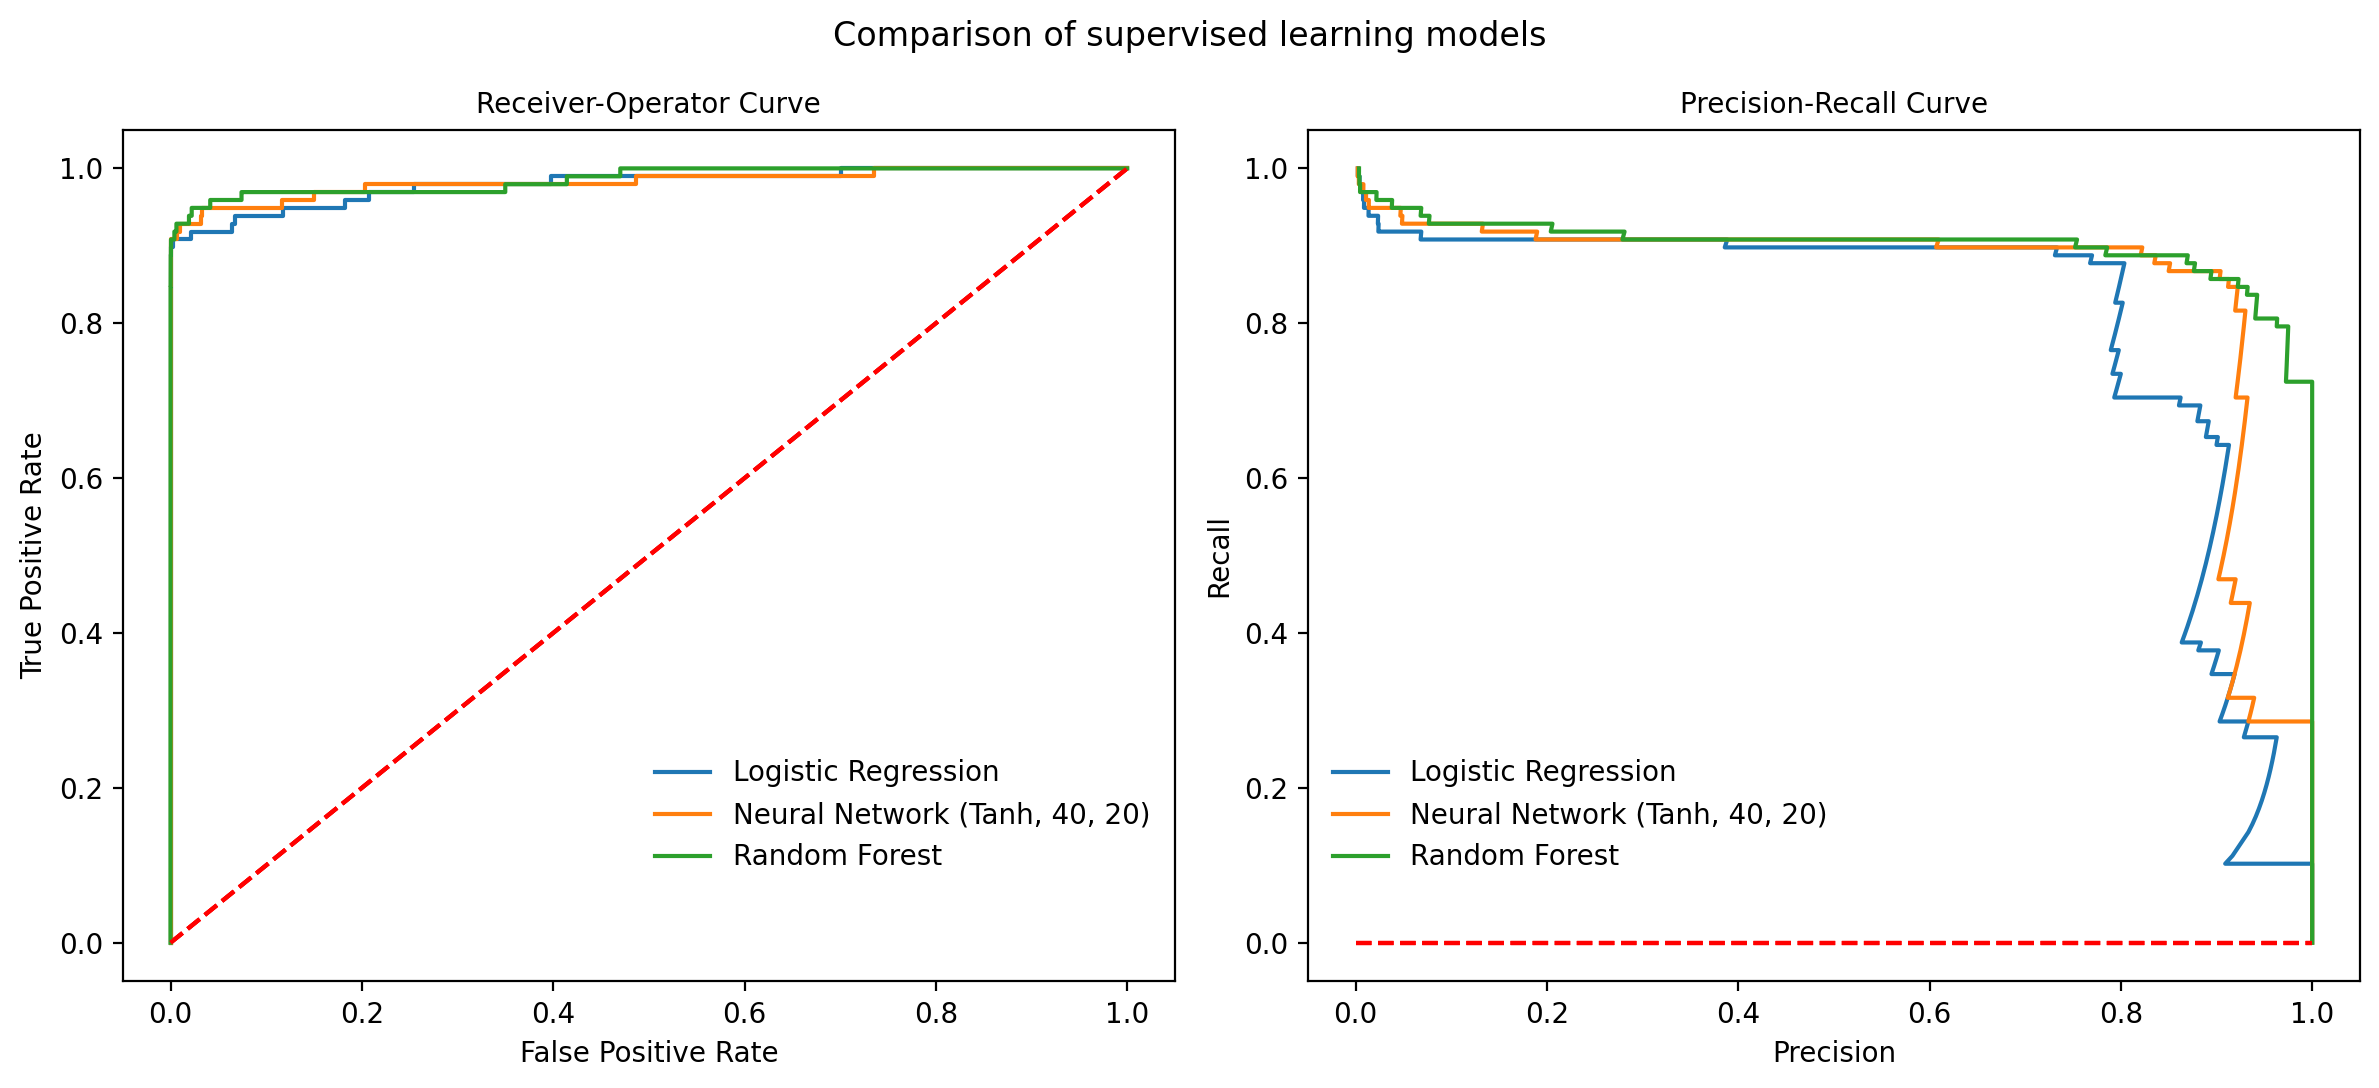

In [97]:
plot_roc_prc([logreg_clf, ann_clf, rf_clf], 
             ['Logistic Regression', 'Neural Network (Tanh, 40, 20)', 'Random Forest'],
             'img/ROC_allinone.png',
             'Comparison of supervised learning models')
